['/Users/RKhanna23/Downloads/events/events_France.json', '/Users/RKhanna23/Downloads/events/events_Spain.json', '/Users/RKhanna23/Downloads/events/events_Germany.json', '/Users/RKhanna23/Downloads/events/events_European_Championship.json', '/Users/RKhanna23/Downloads/events/events_World_Cup.json', '/Users/RKhanna23/Downloads/events/events_Italy.json', '/Users/RKhanna23/Downloads/events/events_England.json']


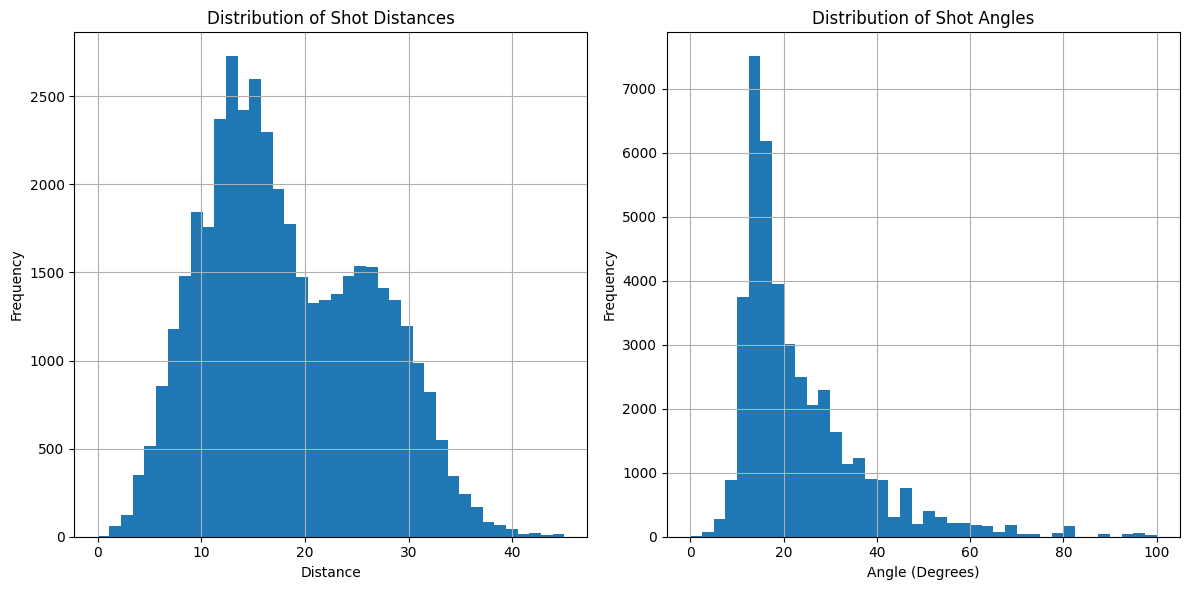

Best Threshold: 0.6567607132545121
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parameters: {'C': 0.012742749857031334, 'penalty': 'l1', 'solver': 'liblinear'}
Best F1 Score: 0.3472111327779174
Accuracy (Best Model): 0.7264698862280213
Precision (Best Model): 0.23235978288963557
Recall (Best Model): 0.6576444769568398
F1 Score (Best Model): 0.34339190221543164
Confusion Matrix (Best Model):
[[8232 2970]
 [ 468  899]]


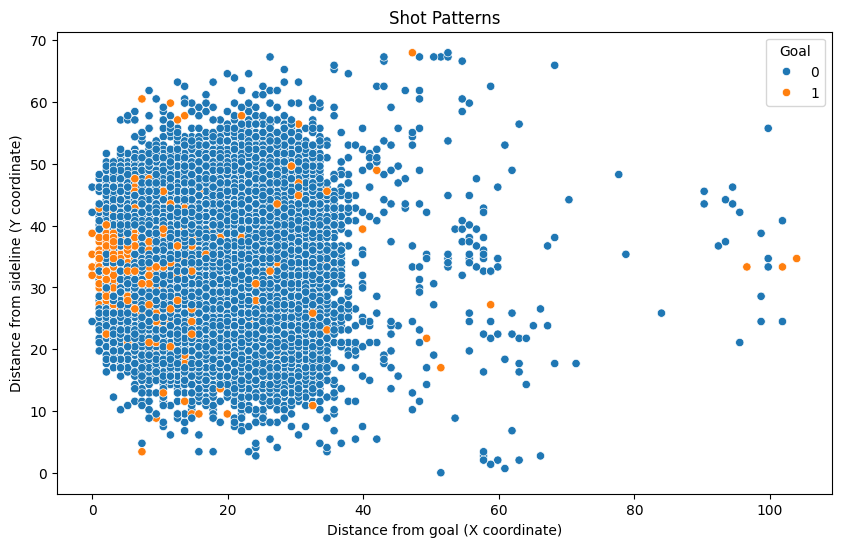

In [2]:
import pandas as pd
import numpy as np
import os
import json
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns


# Load our unprocessed data
directory = '/Users/RKhanna23/Downloads/events'
jsonfiles = []
for path in os.listdir(directory):
    jsonfiles.append(os.path.join(directory,path))
print(jsonfiles)

# Shot Matrix Function
def shot_matrix(eventdata):
    with open(eventdata) as f:
        data = json.load(f)
    
    #Creating the dataframe that we want to store our data in and all the attributes we are interested in 
    shots_dataset = pd.DataFrame(columns=['Goal','x','y','playerid','teamid','matchid','header'])
    
    #Find all the occurences of a shot within the set
    event_df = pd.DataFrame(data)
    all_shots = event_df[event_df['subEventName']=='Shot']
    
    #Fll in our shots_dataset matrix by attribute column by filtering through the all-shot df (dataframe) we just made
    for index,shot in all_shots.iterrows():
        #Fill in the columns for goals and headers with binary descripters
        shots_dataset.at[index,'Goal']=0
        shots_dataset.at[index,'header']=0
        for tag in shot['tags']:
            if tag['id']==101:
                shots_dataset.at[index,'Goal']=1
            elif tag['id']==403:
                shots_dataset.at[index,'header']=1
                
        #Distance from the goal and the angle formed with the goal
        #Wyscouts pitch has its origin at the top left of the pitch and is 100m x 100m, normalize to 105 meters by 68 meters
        shots_dataset.at[index,'Y']=shot['positions'][0]['y']*.68
        shots_dataset.at[index,'X']= (100 - shot['positions'][0]['x'])*1.05
        
        #now we use dummy variables x and y to calc distance and angle attributes
        shots_dataset.at[index,'x']= 100 - shot['positions'][0]['x'] 
        shots_dataset.at[index,'y']=shot['positions'][0]['y']
        shots_dataset.at[index,'Center_dis']=abs(shot['positions'][0]['y']-50)
        
        x = shots_dataset.at[index,'x']*1.05
        y = shots_dataset.at[index,'Center_dis']*.68
        shots_dataset.at[index,'Distance'] = np.sqrt(x**2 + y**2)
        
        #Calculating angle between the width of the goal and the straight line distance to the shot location. 
        
        c=7.32
        a=np.sqrt((y-7.32/2)**2 + x**2)
        b=np.sqrt((y+7.32/2)**2 + x**2)
        k = (c**2-a**2-b**2)/(-2*a*b)
        gamma = np.arccos(k)
        if gamma<0:
            gamma = np.pi + gamma
        shots_dataset.at[index,'Angle Radians'] = gamma
        shots_dataset.at[index,'Angle Degrees'] = gamma*180/np.pi
        
        #Add the identifiers for player, team and match
        shots_dataset.at[index,'playerid']=shot['playerId']
        shots_dataset.at[index,'matchid']=shot['matchId']
        shots_dataset.at[index,'teamid']=shot['teamId']


   
    return shots_dataset

#Read in json files into shot_matrix function
np.seterr(invalid='ignore')

# Reading in JSON files and processing them
all_leagues = []
for file in jsonfiles:
    try:
        all_leagues.append(shot_matrix(file))
    except Exception as e:
        print(f"Error processing file {file}: {e}")

# Concatenating all DataFrames into a single DataFrame
df = pd.concat(all_leagues, ignore_index=True)
df.to_csv('/Users/RKhanna23/Downloads/shot_matrix.csv', index = False)

# Load the dataset
shot_matrix_df = pd.read_csv('/Users/RKhanna23/Downloads/shot_matrix.csv')

# Check for missing values and impute if necessary
shot_matrix_df['Angle Radians'].fillna(shot_matrix_df['Angle Radians'].median(), inplace=True)
shot_matrix_df['Angle Degrees'].fillna(shot_matrix_df['Angle Degrees'].median(), inplace=True)

# Feature selection
features = ['x', 'y', 'header', 'Distance', 'Angle Degrees']
X = shot_matrix_df[features]
y = shot_matrix_df['Goal']


# Plot distributions of shots by distance and angle side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Histogram for Shot Distances
shot_matrix_df.hist("Distance", bins=40, range=(0, 45), ax=axes[0])
axes[0].set_title("Distribution of Shot Distances")
axes[0].set_xlabel("Distance")
axes[0].set_ylabel("Frequency")

# Histogram for Shot Angles
shot_matrix_df.hist("Angle Degrees", bins=40, range=(0, 100), ax=axes[1])
axes[1].set_title("Distribution of Shot Angles")
axes[1].set_xlabel("Angle (Degrees)")
axes[1].set_ylabel("Frequency")

# Display the plot
plt.tight_layout()  
plt.show()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Addressing class imbalance by specifying class weights
# 'balanced' mode uses the values of y to automatically adjust weights inversely proportional to class frequencies
log_reg_model = LogisticRegression(class_weight='balanced')

# Training the model
log_reg_model.fit(X_train, y_train)

# Predict probabilities instead of class labels
y_proba = log_reg_model.predict_proba(X_test)[:, 1]

# Determine the best threshold for maximizing recall and F1 score
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
# Find the threshold that maximizes F1 score
f1_scores = 2*recall*precision / (recall + precision)
best_threshold = thresholds[np.argmax(f1_scores)]
print(f'Best Threshold: {best_threshold}')

# Use the best threshold to make predictions
y_pred_custom_threshold = (y_proba >= best_threshold).astype(int)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(log_reg_model, X, y, cv=5, scoring='f1')

# Define the parameter grid
param_grid = {
    'C': np.logspace(-4, 4, 20),  # Regularization strength
    'penalty': ['l1', 'l2'],      # Type of penalty
    'solver': ['liblinear']       # Algorithm to use for optimization (liblinear is good for small datasets)
}

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(log_reg_model, param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best F1 Score: {grid_search.best_score_}')

# Use the best estimator for further predictions and evaluations
best_model = grid_search.best_estimator_

# Predict on the test set using the best model
y_pred_best = best_model.predict(X_test)

# Calculate metrics using the best model
accuracy_best = accuracy_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)
conf_matrix_best = confusion_matrix(y_test, y_pred_best)

# Print model evaluation metrics using the best model
print(f'Accuracy (Best Model): {accuracy_best}')
print(f'Precision (Best Model): {precision_best}')
print(f'Recall (Best Model): {recall_best}')
print(f'F1 Score (Best Model): {f1_best}')
print(f'Confusion Matrix (Best Model):\n{conf_matrix_best}')



# Visualization of shot patterns
plt.figure(figsize=(10, 6))
sns.scatterplot(data=shot_matrix_df, x='X', y='Y', hue='Goal')
plt.title('Shot Patterns')
plt.xlabel('Distance from goal (X coordinate)')
plt.ylabel('Distance from sideline (Y coordinate)')
plt.show()
